# GOSTrocks Primer

GOSTrocks is an internal sandbox repository that contains commonly used geospatial functions and operations. This notebooks demonstrates the usage of selected functions.

The repository also contains customized code to process specific datasets (GHSL, OpenStreetMap, Nighttime Lights, Fathom). This code is in constant development as project requirements evolve over time.

## Installation

### From PyPI

In [ ]:
pip install GOSTrocks

### From Source

In [ ]:
git clone https://github.com/worldbank/GOSTrocks.git
cd GOSTrocks
pip install .

## Import Functions

GOSTrocks is broken down into modules of functions that share common elements.

In [1]:
import GOSTrocks.dataMisc as dMisc          # search and download specific datasets
import GOSTrocks.ghslMisc as gMisc          # process Global Human Settlement Layer data
import GOSTrocks.mapMisc as mMisc           # cartography functions
import GOSTrocks.metadataMisc as metaMisc   # create and manage metadata
import GOSTrocks.misc as misc               # miscellaneous functions
import GOSTrocks.ntlMisc as nMisc           # Nighttime Lights processing and composing
import GOSTrocks.osmMisc as oMisc           # OpenStreetMap data extraction
import GOSTrocks.rasterMisc as rMisc        # Raster tools!

METADATA Library: Could not import arcgis libraries


## Raster Example

One of the most recurring workflows is to clip and combine raster data from different sources.

Here, we work with population data from WorldPop, and a friction surface from the Malaria Atlas Project, using Ghana as our area of interest.

They are both global datasets with ~1km resolution, so they both need to be clipped and standardized for analysis.

We will use administrative boundaries from the GeoBoundaries API. 

In [2]:
import os
from os.path import join, exists
import urllib.request

import rasterio as rio
from rasterio.plot import show

import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [3]:
country = "Ghana"
iso = "GHA"

### Get Boundaries

In [4]:
dMisc.get_geoboundaries?

Signature:
dMisc.get_geoboundaries(
    iso3,
    level,
    geo_api='https://www.geoboundaries.org/api/current/gbOpen/{iso3}/{adm}/',
)
Docstring:
Download boundaries dataset from geobounadries

:param iso3: ISO3 code of country to download
:type iso3: str
:param level: Admin code to download in format of "ADM1" or "ADM2"
:type level: str
:return: spatial data representing the administrative boundaries
:rtype: gpd.GeoDataFrame
File:      c:\wbg\anaconda3\envs\gost\lib\site-packages\gostrocks\datamisc.py
Type:      function

<Axes: >

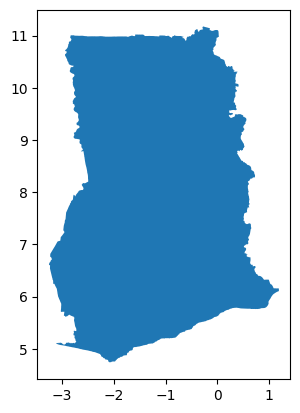

In [5]:
gdf = dMisc.get_geoboundaries(iso, level="ADM0")
gdf.plot()

### Download Population Data

In [6]:
wp_url = f'https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2020/{iso.upper()}/{iso.lower()}_ppp_2020_1km_Aggregated.tif'
wp_url

'https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2020/GHA/gha_ppp_2020_1km_Aggregated.tif'

In [7]:
wp_path = join('..', 'data', f'{iso}_ppp_2020_1km_Aggregated_UNadj.tif') # Download from link above
if not exists(wp_path):
    urllib.request.urlretrieve(wp_url, wp_path)

In [8]:
src_pop = rio.open(wp_path)

(-3.251249987361092, 1.190416661538908, 4.732916852582885, 11.174583493482885)

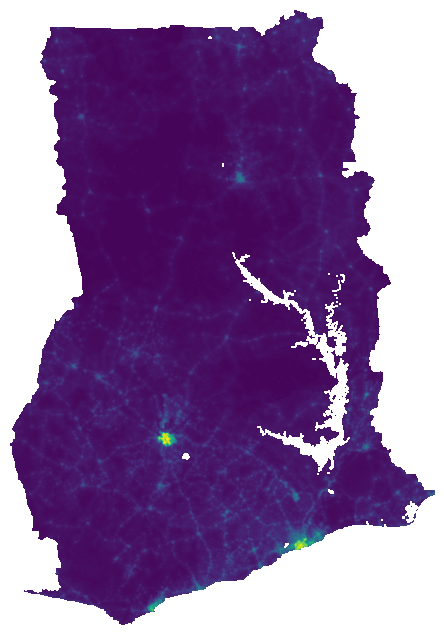

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show(src_pop, norm=colors.PowerNorm(gamma=0.5), cmap='viridis', ax=ax)
plt.axis('off')

### Clip Global Friction Surface

In [10]:
gfs_path = "J:/Data/GLOBAL/INFRA/FRICTION_2020/2020_motorized_friction_surface.geotiff"
src_travel = rio.open(gfs_path)

(-180.0, 180.0, -60.0, 85.0)

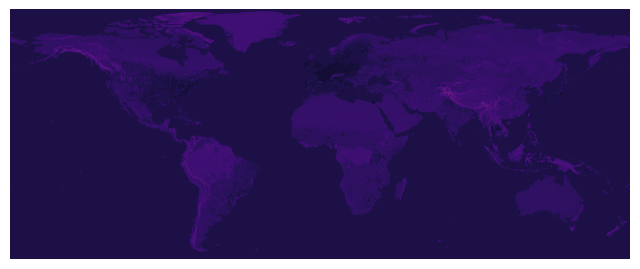

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show(src_travel, norm=colors.PowerNorm(gamma=0.2), cmap='magma', ax=ax)
plt.axis('off')

In [12]:
rMisc.clipRaster?

Signature: rMisc.clipRaster(inR, inD, outFile=None, crop=True)
Docstring:
Clip input raster

:param inR: rasterio object to clip
:type inR: rasterio.DatasetReader
:param inD: geopandas polygonal dataframe to use for clip clip extent based on crop param
:type inD: geopandas.GeoDataFrame
:param outFile: string path to write output raster, default is '' which writes nothing
:type outFile: string
:param crop: determine wether to clip based on bounding box (False) or unary_union (True). Default is True
:type crop: Boolean
:return: array of [numpy array of data, and rasterio metadata]
:rtype: array
File:      c:\wbg\anaconda3\envs\gost\lib\site-packages\gostrocks\rastermisc.py
Type:      function

In [16]:
out_travel = join('..', 'data', f'{iso.upper()}_2020_motorized_friction_surface.tif')
surface, surface_meta = rMisc.clipRaster(src_travel, gdf, outFile=out_travel, crop=False)

(-0.5, 534.5, 772.5, -0.5)

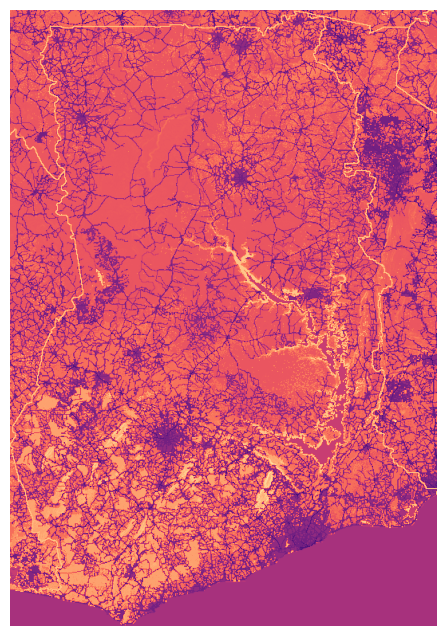

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show(surface, norm=colors.PowerNorm(gamma=0.2), cmap='magma', ax=ax)
plt.axis('off')

### Standardize Rasters

Align the population raster to the friction surface, ensuring that they have the same extent and resolution.

In [18]:
rMisc.standardizeInputRasters?

Signature:
rMisc.standardizeInputRasters(
    inR1,
    inR2,
    inR1_outFile='',
    resampling_type='nearest',
)
Docstring:
Standardize inR1 to inR2: changes crs, extent, and resolution.

:param inR1: rasterio object for raster to be modified
:type inR1: ratserio.DatasetReader
:param inR2: rasterio object to be standardized to
:type inR12 ratserio.DatasetReader
:param inR1_outfile: path to create output raster file of standardized inR1, default is '', which means nothing is written
:type inR1: string
:param resampling_type: how to perfrom spatial resampling; options are nearest (default), cubic, or sum
:type resampling_type: string
:return: array of numpy array, and rasterio metadata
:rtype: array
File:      c:\wbg\anaconda3\envs\gost\lib\site-packages\gostrocks\rastermisc.py
Type:      function

In [19]:
src_travel_clipped = rio.open(out_travel)

In [20]:
pop_std, pop_meta = rMisc.standardizeInputRasters(src_pop, src_travel_clipped, resampling_type="nearest")

Original population raster metadata:

In [21]:
src_pop.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -99999.0,
 'width': 533,
 'height': 773,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0083333333, 0.0, -3.251249987361092,
        0.0, -0.0083333333, 11.174583493482885)}

New population metadata aligned with travel surface:

In [22]:
pop_meta, surface_meta

({'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': -99999.0,
  'width': 535,
  'height': 773,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(0.008333333333333333, 0.0, -3.2583333333333258,
         0.0, -0.008333333333333333, 11.174999999999997)},
 {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': -9999.0,
  'width': 535,
  'height': 773,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(0.008333333333333333, 0.0, -3.2583333333333258,
         0.0, -0.008333333333333333, 11.174999999999997)})

In [27]:
src_pop.close()
src_travel.close()
src_travel_clipped.close()

In [28]:
os.remove(out_travel)
os.remove(wp_path)